We will show how to use differentiability of kornia local features module
by performing an adversarial attack on image matching process. 

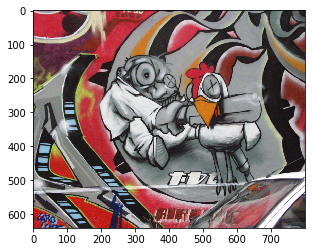

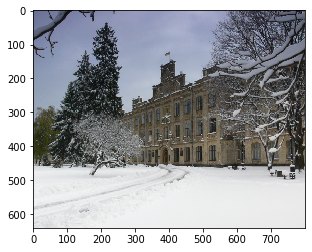

In [1]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

img1 = Image.open('img/graffiti.png')
img2 = Image.open('img/kpi_winter.png').resize(img1.size)

timg = kornia.utils.image_to_tensor(np.array(img1)).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2)).float() / 255.

timg = torch.cat([timg,timg2],dim=0)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))


In [2]:
#Lets define some functions for local feature matching

def distance_matrix(anchor, positive):
    """Given batch of descriptors calculate distance matrix"""
    #https://github.com/DagnyT/hardnet/blob/master/code/Losses.py#L5
    d1_sq = torch.sum(anchor * anchor, dim=1).unsqueeze(-1)
    d2_sq = torch.sum(positive * positive, dim=1).unsqueeze(-1)

    eps = 1e-6
    return torch.sqrt(torch.abs((d1_sq.repeat(1, positive.size(0)) + torch.t(d2_sq.repeat(1, anchor.size(0)))
                      - 2.0 * torch.bmm(anchor.unsqueeze(0), torch.t(positive).unsqueeze(0)).squeeze(0)))+eps)


def match_snn(desc1, desc2, th = 0.8):
    #Lowe distance ratio criterion
    
    dm = distance_matrix(desc1,
                         desc2)
    vals, idxs_in_2 = torch.topk(dm, 2 ,dim=1, largest=False)
    snn_ratio = vals[:,0] / vals[:,1]
    mask = snn_ratio <= th
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))[mask]
    idxs_in_2 = idxs_in_2[:,0][mask]
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return matches_idxs, snn_ratio, vals[:,0]

def match_xyscale(xy1, xy2, s1, s2):
    dm = distance_matrix(xy1/(s1+1e-8), xy2/(s2+1e-8))
    vals, idxs_in_2 = torch.min(dm,dim=1)
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return vals, matches_idxs

def match_nn(d1, d2):
    dm = distance_matrix(d1, d2)
    vals, idxs_in_2 = torch.min(dm,dim=1)
    idxs_in1 = torch.arange(0, idxs_in_2.size(0))
    matches_idxs = torch.cat([idxs_in1.view(-1,1), idxs_in_2.cpu().view(-1,1)],dim=1)
    return vals, matches_idxs

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

In [3]:
#Now lets define local deature detector and descriptor

device = torch.device('cuda:0')
sift = kornia.feature.SIFTDescriptor(32).to(device)
descriptor = sift

resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, 15)
nms = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,2,2), # stride (scale, height, width)
                                       padding=(0, 1, 1)) # nms windows size (scale, height, width)

n_features = 2500
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              mr_size=3.0).to(device)

timg_gray = rgb_to_grayscale(timg).to(device)


Let's detect and visualize features

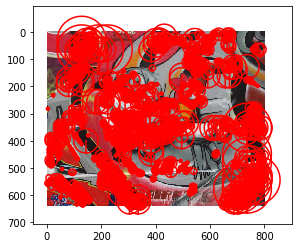

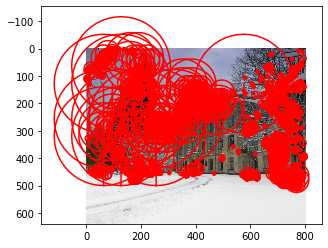

In [4]:
lafs, resps = detector(timg_gray)
patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, 
                                                        kornia.feature.normalize_laf(lafs,timg_gray))
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)

for i in range(2):
    visualize_LAF(timg, lafs, i)

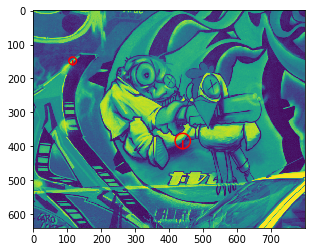

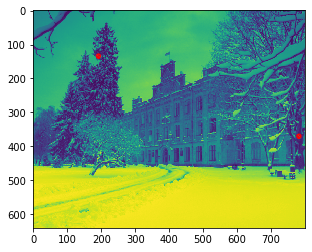

In [5]:
#Now visualize matches
matches, scores, dists = match_snn(descs[0], descs[1])
torch.cat([scores.mean().view(1,1), 1-scores.mean().view(1,1)],dim=1).repeat(2,1)

for i in range(2):
    visualize_LAF(kornia.color.rgb_to_grayscale(timg), lafs[:,matches[i]], i)

In [7]:
device = torch.device('cuda:0')
timgp = Parameter(timg.clone().to(device))
optimizer = optim.Adam([timgp], lr=3e-3)

num_iterations = 40

log_interval = 10

for iter_idx in range(num_iterations):
    # We want image to have valid pixel values at any time
    timg_gray = rgb_to_grayscale((255*timgp).clamp(0,255)/255.).to(device)
    
    # Detect
    lafs, resps = detector(timg_gray)
    
    # Describe
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, 
                                                        kornia.feature.normalize_laf(lafs,timg_gray))
    B, N, CH, H, W = patches.size()
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    B,N,_,_ = lafs.size()

        # Location loss
    xy = lafs[:,:,:2,2]
    scale = kornia.feature.get_laf_scale(lafs)
    xy_diff, closest_lafs_idxs = match_nn(xy[0].view(N,-1), 
                                          xy[1].view(N,-1))
    mask_det = (xy_diff < 5.0) * (xy_diff > 0.5)
    det_xy_loss = (xy[0, closest_lafs_idxs[:,0][mask_det]] - xy[1, closest_lafs_idxs[:,1][mask_det]]).pow(2).sum(dim=1).abs().sqrt().mean()
    det_scale_loss = (scale[0, closest_lafs_idxs[:,0][mask_det]] - scale[1, closest_lafs_idxs[:,1][mask_det]]).pow(2).sum(dim=1).sum(dim=1).sqrt().mean()
    
    # Descriptor loss
    mask = mask_det
    dm = distance_matrix(descs[0],
                         descs[1])
    pos_dist = dm[closest_lafs_idxs[:,0],
                  closest_lafs_idxs[:,1]].clone()
    dm2 = dm.clone();
    dm2[closest_lafs_idxs[:,0][mask],closest_lafs_idxs[:,1][mask]] = 100
    min_neg = torch.min(dm2,1)[0]
    descriptor_loss = pos_dist[mask].mean()#(descs[0, closest_lafs_idxs[:,0]]- descs[1, closest_lafs_idxs[:,1]]).pow(2).sum(dim=1).sqrt()[mask].mean()
    descriptor_loss2 = (1.0 + pos_dist[mask] - (min_neg[mask].detach()+1e-8)).clamp(min=0,max=2.0).mean()
    detector_loss = det_xy_loss#+0.0*det_scale_loss
    
    # We want also not to deviate far from original images
    reg_loss = F.mse_loss(timgp, timg.clone().to(device))
    loss = 1.0*detector_loss + 0.1*reg_loss + 1.5*descriptor_loss2# + 0.2 * det_scale_loss
        
    # compute gradient and update optimizer parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if iter_idx % log_interval == 0 or iter_idx == num_iterations-1:
        print('Opt iteration: {}/{}\txyLoss: {:.4}\t  DescLoss: {:.4}'.format(
        iter_idx, num_iterations, det_xy_loss.item(),descriptor_loss.item()))
        with torch.no_grad():
            matches, scores, dists = match_snn(descs[0], descs[1])
        print ('num desc matches', len(matches),  'num same locations detections', mask.float().sum().item())

Opt iteration: 0/40	xyLoss: 3.183	  DescLoss: 1.363
num desc matches 198 num same locations detections 147.0
Opt iteration: 10/40	xyLoss: 2.851	  DescLoss: 0.3778
num desc matches 1093 num same locations detections 150.0
Opt iteration: 20/40	xyLoss: 2.828	  DescLoss: 0.124
num desc matches 827 num same locations detections 193.0
Opt iteration: 30/40	xyLoss: 2.794	  DescLoss: 0.08282
num desc matches 943 num same locations detections 236.0
Opt iteration: 39/40	xyLoss: 2.814	  DescLoss: 0.1329
num desc matches 794 num same locations detections 292.0


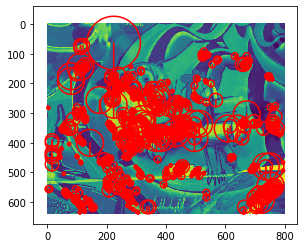

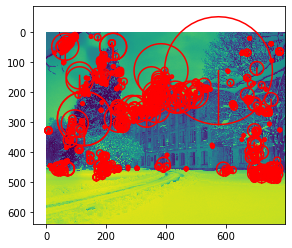

In [8]:
# Now visialize all matches, which survive SNN=0.8 Lowe criterion
timg_at = timgp.detach().clone()
timg_at_valid = (timg_at * 255.).clamp(0,255).floor()
timg_at_valid_gray = kornia.color.rgb_to_grayscale(timg_at_valid)
i1 = Image.fromarray(kornia.utils.tensor_to_image(timg_at_valid[1]).astype(np.uint8))
i1.save('kpi_at.png')
#plt.imshow(i1)
#plt.figure()
i2 = Image.fromarray(kornia.utils.tensor_to_image(timg_at_valid[0]).astype(np.uint8))
i2.save('graf_at.png')
#plt.imshow(i2)

lafs, resps = detector(timg_at_valid_gray.to(device)/255.)    
# Describe
patches =  kornia.feature.extract_patches_from_pyramid(timg_at_valid_gray, 
                                                        kornia.feature.normalize_laf(lafs,timg_at_valid_gray))
B, N, CH, H, W = patches.size()
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    
matches, scores, dists = match_snn(descs[0], descs[1])

for i in range(2):
    visualize_LAF(timg_at_valid_gray, lafs[:,matches[:,i]], i)


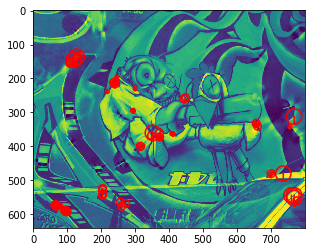

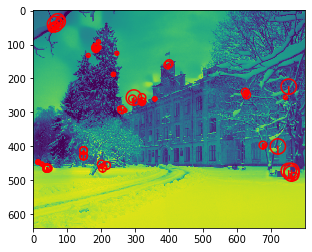

In [13]:
# Now check if matches survive RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0, 0.99, 100000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_at_valid_gray, lafs[:,inliers[:,i]], i)


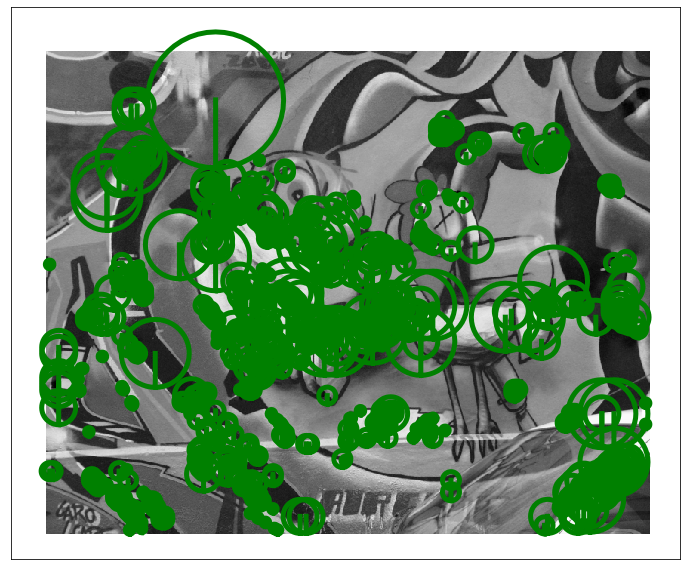

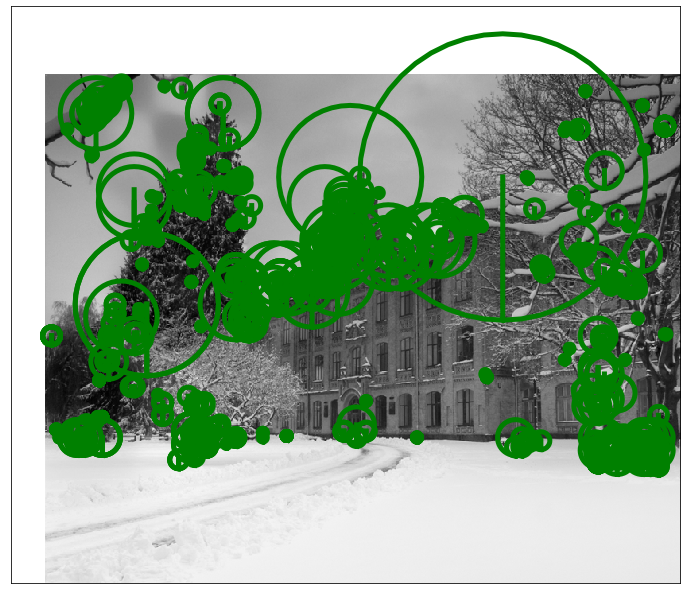

In [14]:
import seaborn as sns

color = 'g'
for img_idx in range(2):
    LAF = lafs[:,matches[:,img_idx]]
    pts = kornia.feature.laf.laf_to_boundary_points(LAF[img_idx:img_idx + 1])[0]
    pts_np = pts.detach().permute(1, 0, 2).cpu().numpy()
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    fig.subplots_adjust(hspace = 0, wspace = 0)
    ax.imshow(kornia.utils.tensor_to_image(timg_at[img_idx].mean(dim=0)),cmap='gray')
    ax.plot(pts_np[:, :, 0], pts_np[:, :, 1], color, linewidth=5)
    ax.grid('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    plt.show()
    fig.savefig(str(img_idx)+'.pdf', bbox_inches = 'tight',  pad_inches = 0)



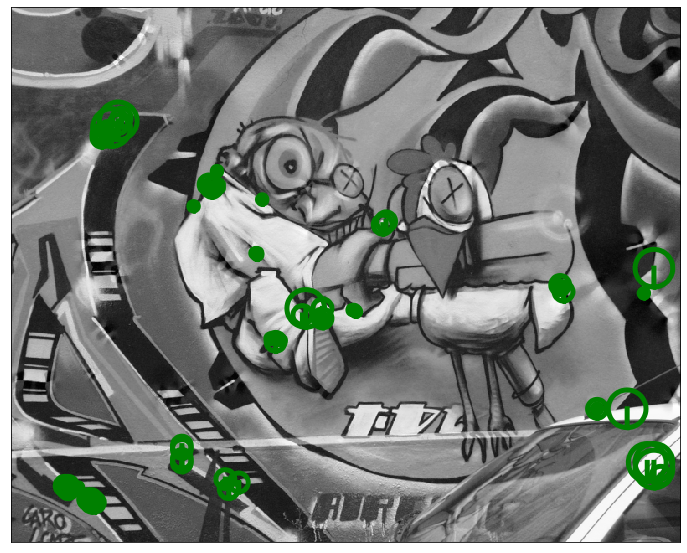

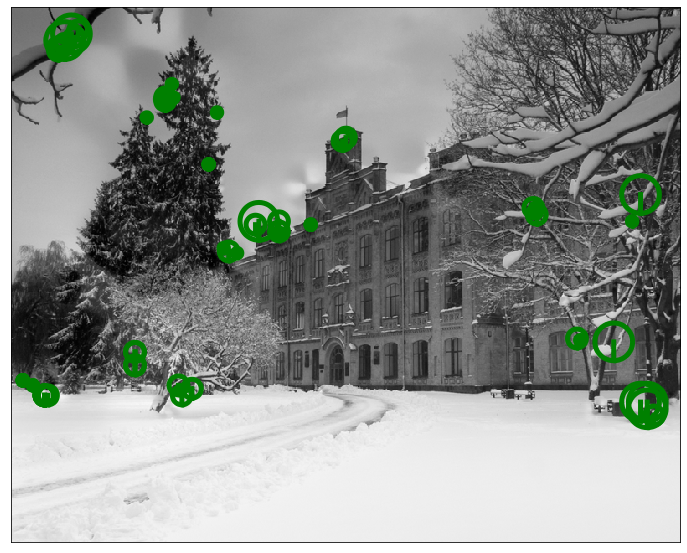

In [15]:
import seaborn as sns

color = 'g'
for img_idx in range(2):
    LAF = lafs[:,inliers[:,img_idx]]
    pts = kornia.feature.laf.laf_to_boundary_points(LAF[img_idx:img_idx + 1])[0]
    pts_np = pts.detach().permute(1, 0, 2).cpu().numpy()
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    fig.subplots_adjust(hspace = 0, wspace = 0)
    ax.imshow(kornia.utils.tensor_to_image(timg_at[img_idx].mean(dim=0)),cmap='gray')
    ax.plot(pts_np[:, :, 0], pts_np[:, :, 1], color, linewidth=5)
    ax.grid('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    plt.show()
    fig.savefig(str(img_idx)+'_inl.pdf', bbox_inches = 'tight',  pad_inches = 0)

